> ### 參考依據 https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification


### Import Library

In [35]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

print(os.listdir("final"))

print(os.listdir("final/kaggle_dogcat"))

os.environ["CUDA_VISIBLE_DEVICE"] = "0"

['.ipynb_checkpoints', 'data.zip', 'Day_101~103_2nd ver.ipynb', 'final .ipynb', 'Final_Exam.csv', 'kaggle_dogcat', 'ml-marathon-final.zip', 'model.h5', 'sample_submission.csv', 'submission.csv']
['test', 'train']


### Define Constants

In [47]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Prepare Traning Data

In [48]:
filenames = os.listdir("final/kaggle_dogcat/train/all")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [49]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [50]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


### See Total In count

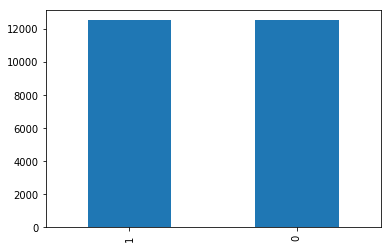

In [51]:
df['category'].value_counts().plot.bar()

### See sample image

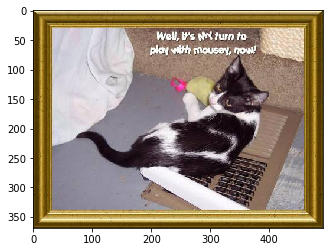

In [52]:
sample = random.choice(filenames)
image = load_img("final/kaggle_dogcat/train/all/"+sample)
plt.imshow(image)

* Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* Conv Layer: This layer will extract features from image.
* Pooling Layer: This layerreduce the spatial volume of input image after convolution.
* Fully Connected Layer: It connect the network from a layer to another layer
* Output Layer: It is the predicted values layer.

### Build Model

### Callbacks

In [53]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-5)

callbacks = [earlystop, learning_rate_reduction]

### Prepare data

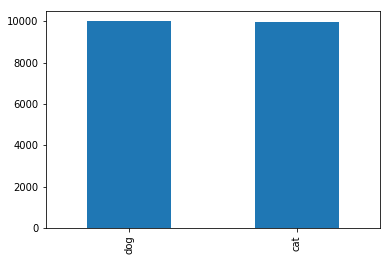

In [54]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

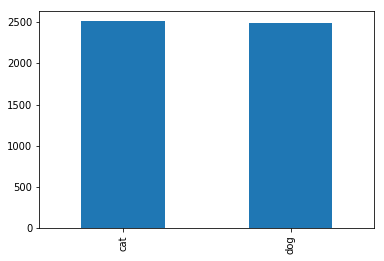

In [55]:
validate_df['category'].value_counts().plot.bar()

In [56]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16

### Traning Generator

In [57]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "final/kaggle_dogcat/train/all", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [58]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
__________

### Validation Generator

In [59]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "final/kaggle_dogcat/train/all", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


### See how our generator work

In [60]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "final/kaggle_dogcat/train/all", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


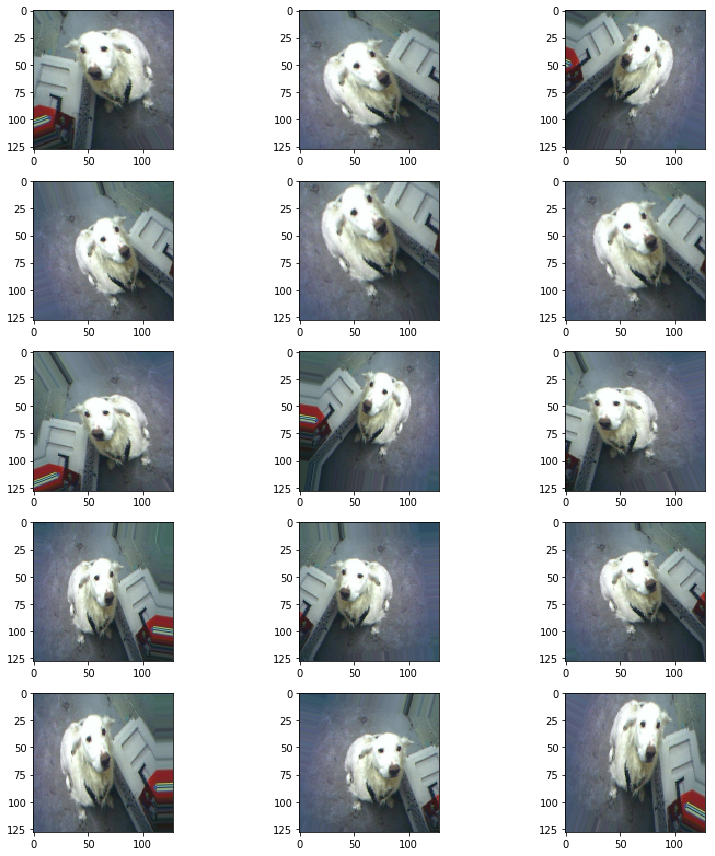

In [61]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Fit Model

In [64]:
epochs=5 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/5
1250/1250 [==============================] - 511s 409ms/step - loss: 0.4828 - acc: 0.7710 - val_loss: 0.6285 - val_acc: 0.7041
Epoch 2/5
1250/1250 [==============================] - 454s 364ms/step - loss: 0.4726 - acc: 0.7782 - val_loss: 0.4855 - val_acc: 0.8052
Epoch 3/5
1250/1250 [==============================] - 370s 296ms/step - loss: 0.4625 - acc: 0.7866 - val_loss: 0.3846 - val_acc: 0.8240
Epoch 4/5
1250/1250 [==============================] - 393s 314ms/step - loss: 0.4574 - acc: 0.7898 - val_loss: 0.4555 - val_acc: 0.7955
Epoch 5/5
1250/1250 [==============================] - 432s 346ms/step - loss: 0.4599 - acc: 0.7853 - val_loss: 0.4516 - val_acc: 0.7869

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


### Save Model

In [65]:
model.save_weights("final/model.h5")

### Virtualize Training

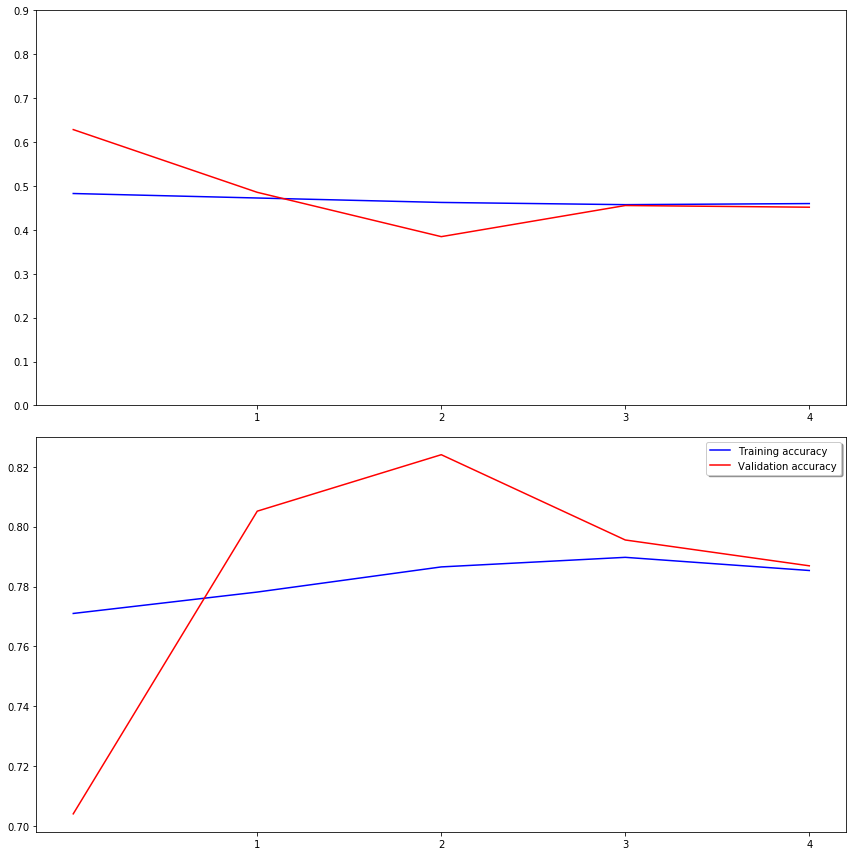

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Prepare Testing Data

In [67]:
test_filenames = os.listdir("final/kaggle_dogcat/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

### Create Testing Generator

In [68]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "final/kaggle_dogcat/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 400 validated image filenames.


### Predict

In [69]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

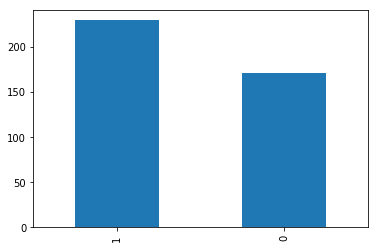

In [70]:
test_df['category'].value_counts().plot.bar()

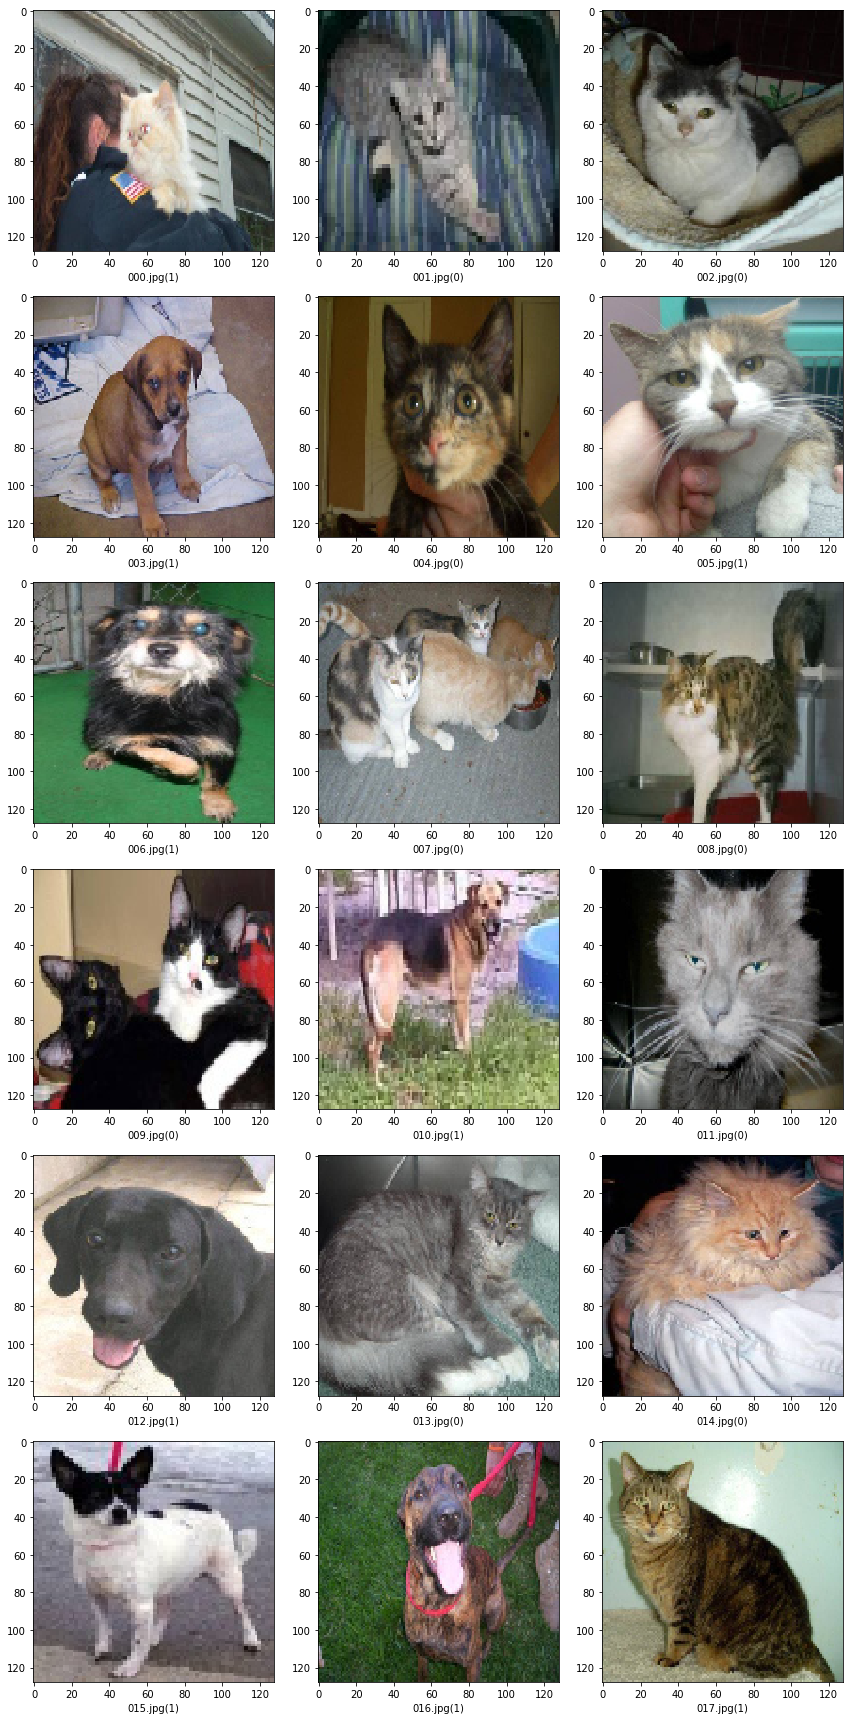

In [71]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("final/kaggle_dogcat/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

### Submission

In [72]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['Predicted'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('final/submission.csv', index=False)